In [6]:
library('zoo')
library('forecast')
library('readxl')

Warning message:
"package 'readxl' was built under R version 4.0.5"


In [12]:
data <- read.csv("../dataset/期货价格数据/使用数据/CBOT大豆周连续.csv",head=F)
head(data)

,V1,V2
,<chr>,<dbl>
1,1972/1/10,304.63
2,1972/1/17,307.63
3,1972/1/24,309.38
4,1972/1/31,318.75
5,1972/2/7,314.75
6,1972/2/14,314.38


In [17]:
data2 <- data[2]
data_ts <- ts(data2,start=1,frequency=52)
head(data_ts)

V2
304.63
307.63
309.38
318.75
314.75
314.38


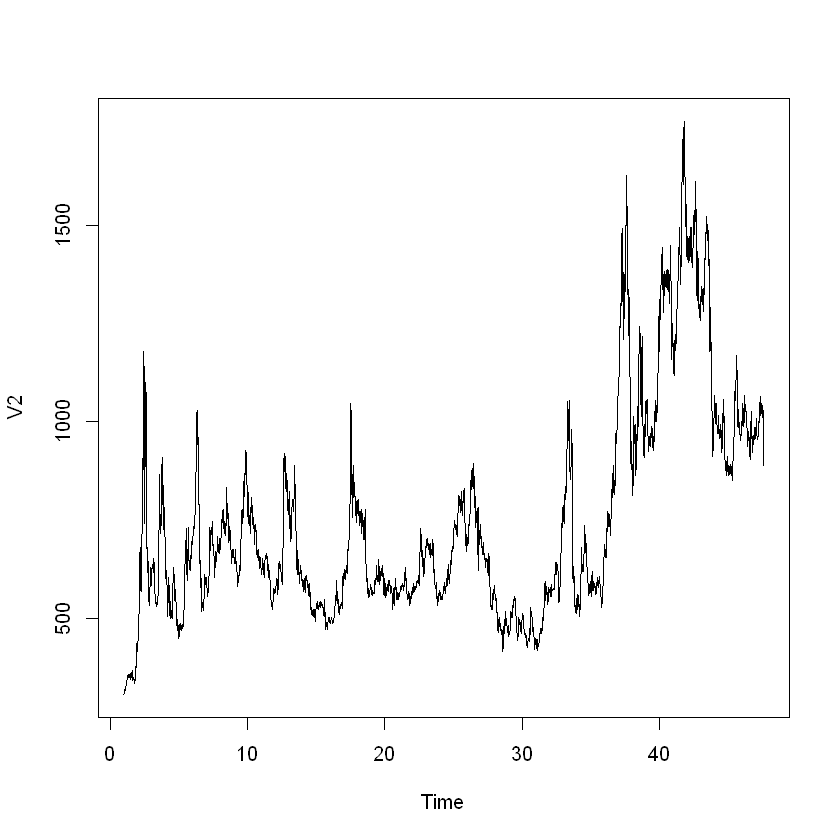

In [18]:
plot.ts(data_ts)

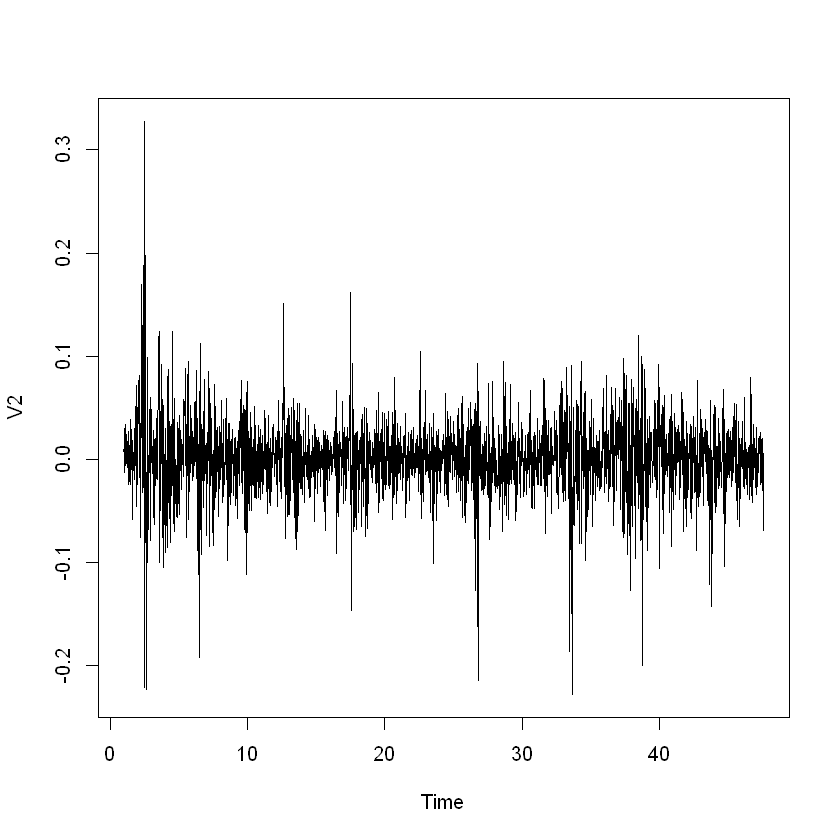

In [29]:
# par(pin = c(6,4))
datalog <- log(data_ts)
datadiff <- diff(datalog, differences=1)
plot.ts(datadiff)

In [30]:
# 上面都是在胡扯
# 下面是根据老师的代码写的

In [53]:
# 设置工作目录并读取数据
# setwd('../dataset/期货价格数据/使用数据/')
da <- read.csv("./黄金周数据.csv",head=F)
names(da) <- c('date','price')
head(da)

,date,price
,<chr>,<dbl>
1,2008/1/14,223.30
2,2008/1/21,223.80
3,2008/1/28,206.42
4,2008/2/4,222.56
5,2008/2/11,215.26
6,2008/2/18,213.69


A Time Series:
[1] 223.30 223.80 206.42 222.56 215.26 213.69

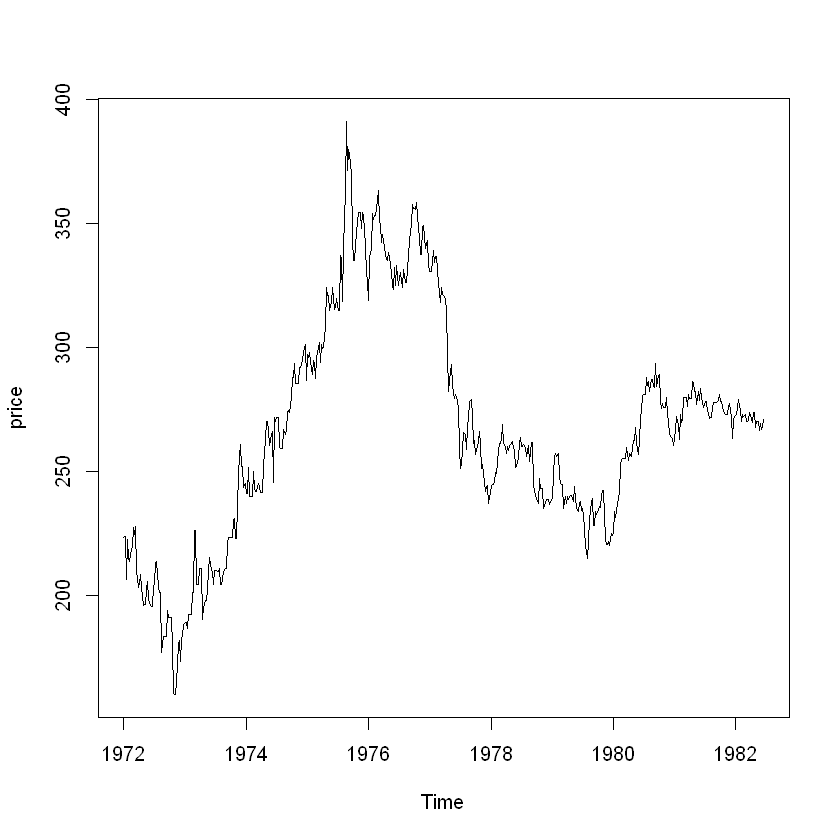

In [54]:
# 转换为时间序列
price = ts(da$price,frequency=52,start=c(1972,1,10))
head(price)
plot.ts(price)

In [55]:
# 计算对数差分收益率
price_log <- log(price)
returns <- diff(price_log, differences=1)

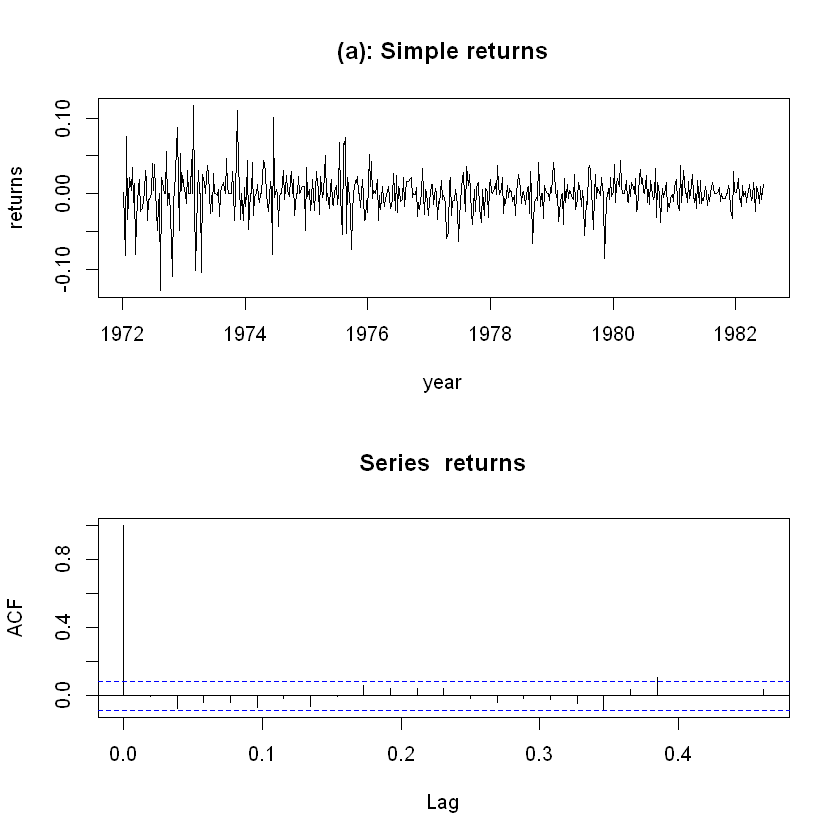

In [60]:
# 进行acf检验
par(mfcol = c(2,1))
plot(returns,xlab='year',ylab='returns')
title(main='(a): Simple returns')
acf(returns,lag=24)

, , 1

               [,1]
 [1,]  1.0000000000
 [2,] -0.0008958461
 [3,] -0.0752075594
 [4,] -0.0410657964
 [5,] -0.0400923794
 [6,] -0.0696748192
 [7,] -0.0138059076
 [8,] -0.0599032059
 [9,] -0.0060400759
[10,]  0.0638769324
[11,]  0.0410742815
[12,]  0.0433260156
[13,]  0.0427193590
[14,] -0.0139690887
[15,] -0.0380215330
[16,] -0.0169620779
[17,] -0.0201214857
[18,] -0.0459361358
[19,] -0.0809215273
[20,]  0.0353434268
[21,]  0.1096166823
[22,]  0.0049791858
[23,]  0.0019584213
[24,]  0.0015549918
[25,]  0.0398671305

[1] 545

[1] 0.9972935

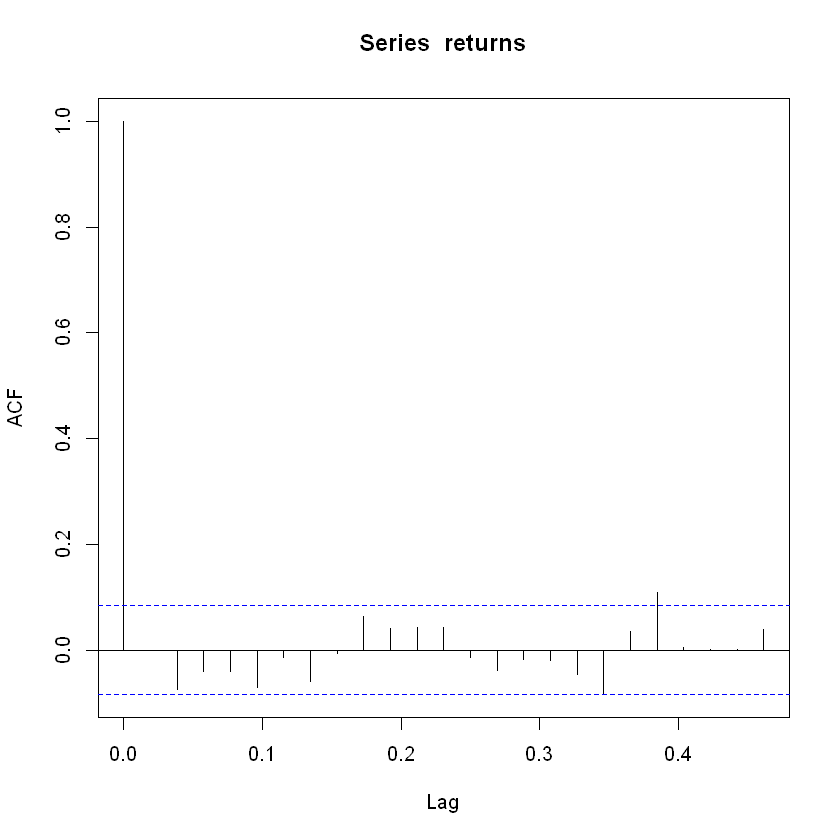

In [63]:
# 检验单个acf
f1=acf(returns,lag=24)
f1$acf
tt=f1$acf[13]*sqrt(dim(da)[1])
tt

In [64]:
# Ljung-Box Q statistics 白噪声检验
# lnibm=log(ibm+1) # Transfer to log returns
Box.test(price,lag=12,type='Ljung')
Box.test(price_log,lag=12,type='Ljung')


	Box-Ljung test

data:  price
X-squared = 5897.6, df = 12, p-value < 2.2e-16



	Box-Ljung test

data:  price_log
X-squared = 5883.6, df = 12, p-value < 2.2e-16


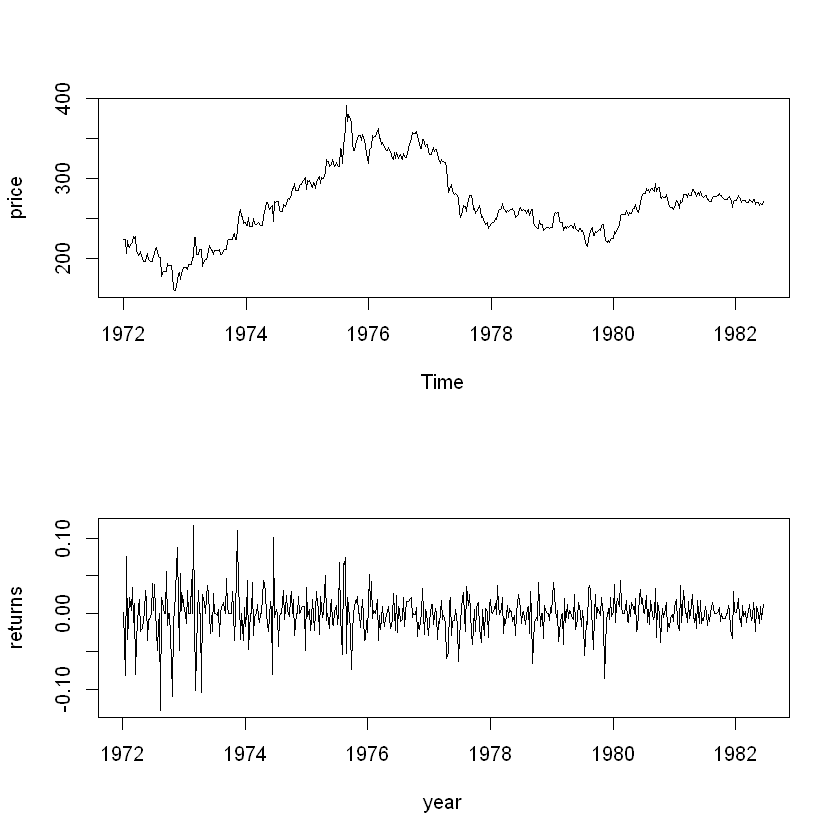

In [65]:
# AR models
par(mfcol=c(2,1))
plot.ts(price)
plot(returns,xlab='year',ylab='returns')

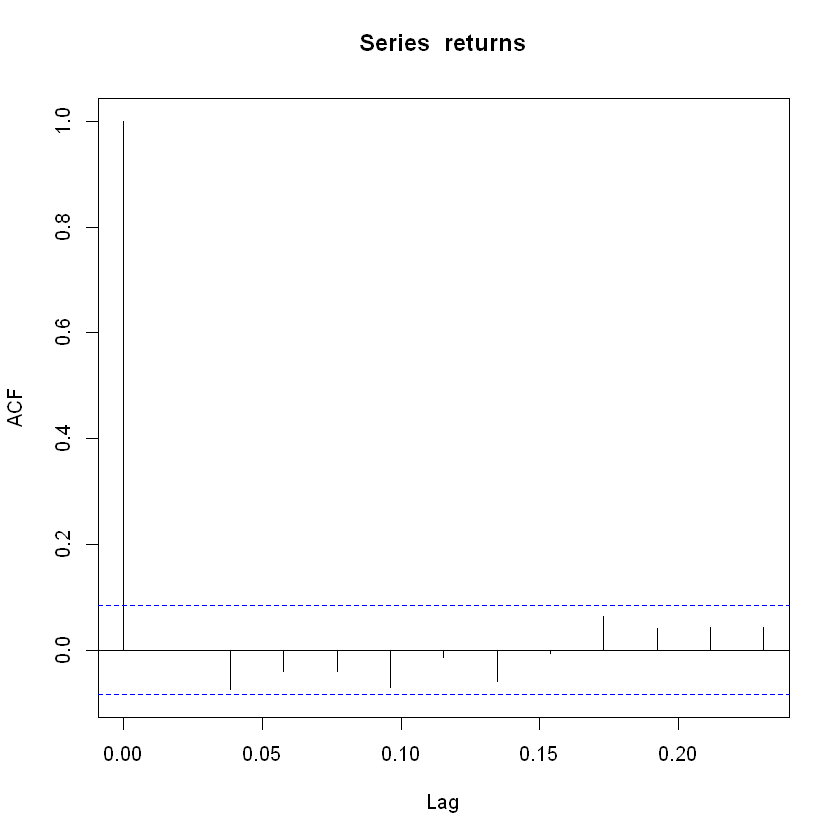

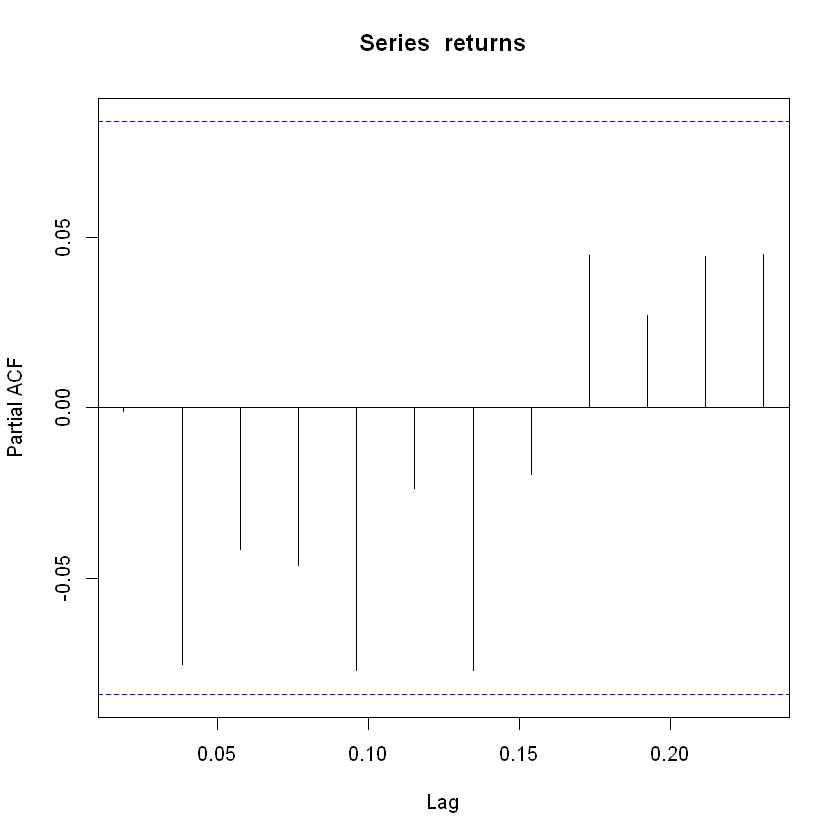

In [66]:
acf(returns,lag=12)
pacf(returns,lag=12) # compute PACF

In [67]:
m1=arima(returns,order=c(3,0,0))
m1
m12=arima(returns,order=c(1,0,0))
m12
m13=arima(returns,order=c(2,0,0))
m13
m14=arima(returns,order=c(1,0,2))
m14
m15=arima(returns,order=c(3,0,2))
m15


Call:
arima(x = returns, order = c(3, 0, 0))

Coefficients:
          ar1      ar2      ar3  intercept
      -0.0041  -0.0757  -0.0414      4e-04
s.e.   0.0428   0.0431   0.0435      1e-03

sigma^2 estimated as 0.0006331:  log likelihood = 1231.32,  aic = -2452.64


Call:
arima(x = returns, order = c(1, 0, 0))

Coefficients:
          ar1  intercept
      -0.0009     0.0004
s.e.   0.0428     0.0011

sigma^2 estimated as 0.0006379:  log likelihood = 1229.3,  aic = -2452.6


Call:
arima(x = returns, order = c(2, 0, 0))

Coefficients:
          ar1      ar2  intercept
      -0.0009  -0.0764      4e-04
s.e.   0.0427   0.0431      1e-03

sigma^2 estimated as 0.0006342:  log likelihood = 1230.87,  aic = -2453.74


Call:
arima(x = returns, order = c(1, 0, 2))

Coefficients:
         ar1      ma1      ma2  intercept
      0.6305  -0.6428  -0.0844      4e-04
s.e.  0.1534   0.1566   0.0479      8e-04

sigma^2 estimated as 0.0006288:  log likelihood = 1233.17,  aic = -2456.35

Warning message in sqrt(diag(x$var.coef)):
"产生了NaNs"



Call:
arima(x = returns, order = c(3, 0, 2))

Coefficients:
         ar1     ar2      ar3      ma1      ma2  intercept
      0.2018  0.3057  -0.0449  -0.2136  -0.3901      4e-04
s.e.     NaN     NaN      NaN      NaN      NaN      8e-04

sigma^2 estimated as 0.0006287:  log likelihood = 1233.21,  aic = -2452.42

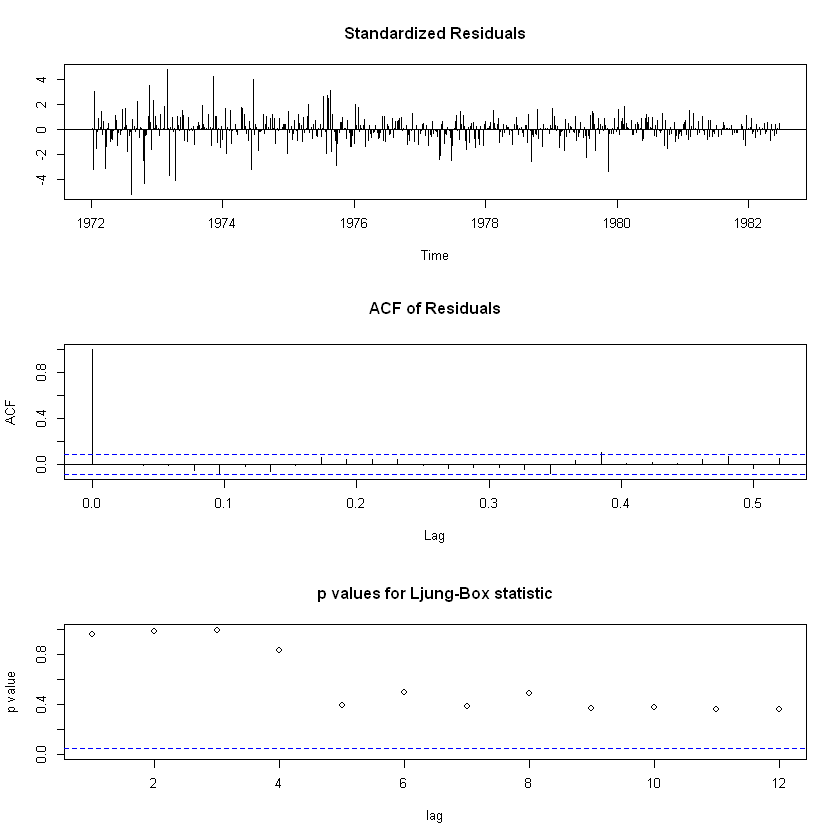

In [68]:
tsdiag(m1,gof=12)  # model checking discussed later

In [69]:
p1=c(1,-m1$coef[1:3]) # set-up the polynomial
r1=polyroot(p1) # solve the polynomial equation
r1
Mod(r1)
k=2*pi/acos(1.616116/1.832674) # compute length of the period
k

[1]  0.901687+2.416574i -3.634301-0.000000i  0.901687-2.416574i

[1] 2.579316 3.634301 2.579316

[1] 12.79523

[1] 0

    0     1     2     3     4     5     6     7     8     9    10    11    12 
0.000 2.000 0.918 1.984 2.819 1.439 3.141 1.879 3.701 4.580 6.211 7.126 8.023 


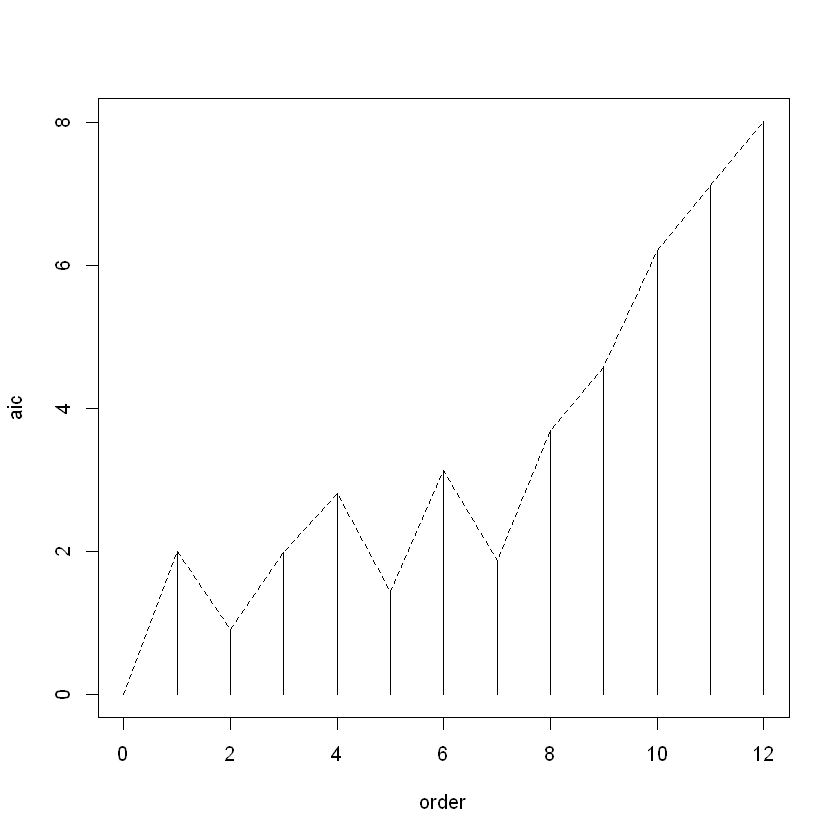

In [73]:
####AR order identification 
mm1=ar(returns,method='mle')
mm1$order # Find the identified order 
print(mm1$aic,digits=3)
aic=mm1$aic  # For plotting below.
plot(c(0:(length(aic)-1)),aic,type='h',xlab='order',ylab='aic')
lines(0:(length(aic)-1),aic,lty=2)